In [3]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel

DIVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATCH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATCH / 'morse_dataset'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 180
TOP_DB = 80
FREQ_MASK = 30
TIME_MASK = 40

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.002 #2e-4
WEIGHT_DECAY = 0.00001
# int_to_alph = dict(enumerate(MORSEALP))
# alph_to_int = {char:enum for enum, char in int_to_alph.items()}

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'sample_submission.csv'))

class MosreDataset(Dataset):
    """
    Класс для обработки 
    """
    def __init__(self, df, data_patch, train=True, transforms=None, prev_chars = 1):
        self.df = df
        self.is_train = train

        self.data_path = data_patch
        self.audio_paths = self.data_path / 'morse_dataset'

        self.transforms = transforms

        self.morse_alp = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
        self.int_to_alph = dict(enumerate(MORSEALP, start=1)) # 0 - Выводим под пустое
        self.alph_to_int = {char:enum+1 for enum, char in self.int_to_alph.items()}
        self.prev_chars = prev_chars

        if self.is_train:
            self.messeges = self.df.message.values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #Получение аугментрованых спектрограмм
        try:
            audio_file = self.audio_paths / self.df.id.values[index]
            waveform, sample_rate = torchaudio.load(audio_file)
            augmented_spectrogram = self.transforms(waveform)

            if self.is_train:
                message = self.messeges[index]
                #Получение списка индексов секта - как требует CTC los
                '''
                При обработке dataloader labels будут выравниваться по макс длине для выравнивания батча
                Т.е. будет padding 0. что в будующем будет пустым значением для ctc loss
                '''
                label = torch.LongTensor([self.morse_alp.find(c) + 1 for c in message])
                label_len = torch.LongTensor([len(label)])
                return augmented_spectrogram, label, label_len, message
            else:
                return augmented_spectrogram
        except Exception as ex:
            print(str(ex))
        
    def change_time(self, audio_file, max_len = 384000):
        waveform, sample_rate = torchaudio.load(audio_file)
        cahanal, sig_len = waveform.shape

        if sig_len < max_len:
            pad_len = torch.zeros(max_len - sig_len).unsqueeze(0)
            waveform = torch.cat([waveform, pad_len], dim=1)

        return waveform
    
FIRST_FE_COUNT = 16
SECOND_FE_COUNT = 32
THIRD_FE_COUNT = 32
QAD_FE_COUNT = 32
PADDING = 'same'
MAXPOOL_KERNEL = 2
KERTNEL_SIZE = 3
NERON_COUNT = 128
GRU_HIDEN = 256
DROPOUT = 0.45

NUM_HEADS = 8#?
# Start with 4 transforms
class MorseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((1, 2), (1, 2)), # [batch, FIRST_FE_COUNT = 16, 64, 960]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)), # [batch, SECOND_FE_COUNT = 32, 32, 480]

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 2), (2, 2)), # [batch, THIRD_FE_COUNT = 32, 16, 240]

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)) # [batch=32, QAD_FE_COUNT = 32, 8, 80](что юы сохраниить большще признаков по горизонтали)
        )
        with torch.no_grad(): 
            dummy_input = torch.randn(1, 1, N_MELS, 480); 
            cnn_out = self.net_conv(dummy_input); 
            self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]
        print(f"CNN размерность выхода: {cnn_out.shape}"); 
        print(f"CNN число фичей: {self.cnn_output_features}")

        # Добавлен лоейный слой и функция активации. Для чего? расписать потом 
        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2); 
        self.gelu = nn.LeakyReLU()
        print(f"Проекция из {self.cnn_output_features} в {GRU_HIDEN*2}")
        self.rnn = nn.GRU(input_size=N_MELS*2,hidden_size=GRU_HIDEN, num_layers=3 ,bidirectional=True,dropout=DROPOUT)
        
        self.embed_dim = GRU_HIDEN * 2
        self.mha = nn.MultiheadAttention(self.embed_dim, NUM_HEADS, dropout=DROPOUT, batch_first=True)
        self.dropout_mha = nn.Dropout(DROPOUT)
        self.layer_norm = nn.LayerNorm(self.embed_dim)      
        self.layer2 = nn.Linear(self.embed_dim, len(MORSEALP))       
        # self.layer3 = nn.Linear(GRU_HIDEN, GRU_HIDEN // 2)       
        # self.layer4 = nn.Linear(GRU_HIDEN // 2, 45)             

    def forward(self, x):
        x = self.net_conv(x)

        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, mels]
        # В частности, каждый вектор признаков в последовательности признаков генерируется 
        # слева направо на картах признаков. Это означает, что i-й вектор признаков представляет 
        # собой объединение столбцов всех карт. 
        # Таким образом, форма тензора может быть изменена, например, на (размер_пакета, 80, 256)
        x = x.reshape(batch, reduced_time, -1)  # to GRU [batch=32, seq_len=80, features=256]
        x = self.layer1(x)
        x = self.gelu(x)
        self.rnn.flatten_parameters()
        x = self.rnn(x)
        x, _ = x # берем информацию со всез состояний
        attn_output, _ = self.mha(x, x, x)
        x = x + self.dropout_mha(attn_output)
        x = self.layer_norm(x)
        x = self.layer2(x)
        x = nn.functional.log_softmax(x.permute(1, 0, 2), dim=2)
        # x = self.layer3(x)
        # x = self.layer4(x)
        # x = x.log_softmax(dim=2) #log_softmax дает лучше распределение вероятностей чем softmax

        return x
    

train_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    # transforms.AmplitudeToDB(top_db=TOP_DB),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK),
    transforms.TimeMasking(time_mask_param=TIME_MASK),
    # v2.RandomCrop((N_MELS, 1920)) # Обрезает последний кадр спектрограммы, в идеале надобы считать а не прописывать число
    ) # заметка - Данные трансформации не создают довых обучаемых параметров. Но есть и те что создают. В будущем это стоит учитывать

valid_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    # transforms.AmplitudeToDB(top_db=TOP_DB),
    # v2.CenterCrop((N_MELS, 1920)) 
    )

train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.15, random_state=SEED)

train_ds = MosreDataset(df=train_dataframe,
                        data_patch=DATASET_PATCH,
                        train=True,
                        transforms=train_audio_transforms)

val_ds = MosreDataset(df=val_dataframe,
                        data_patch=DATASET_PATCH,
                        train=True,
                        transforms=valid_audio_transforms)

def my_collate(batch):
    data = torch.stack([item[0] for item in batch])
    target = torch.nn.utils.rnn.pad_sequence(
                                            [item[1] for item in batch], 
                                            batch_first=True, 
                                            padding_value=0) # выравнивает последовательность до макс 
                                                            # длины в датче заполняя пропуски нулем
    label_len = torch.stack([item[2] for item in batch])
    msg = [item[3] for item in batch]
    
    return [data, target, label_len, msg]

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate)

test, test_target, _, mess = next(iter(train_dl))
test, test_target= test.to(DIVICE), test_target.to(DIVICE)

test_val, val_target, _, val_mess = next(iter(val_dl))
test_val, val_target = test_val.to(DIVICE), val_target.to(DIVICE)
# test.shape 

#===== начало обучения =====
model = MorseNet().to(DIVICE)
model = DataParallel(model)
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=6, verbose=True)
loss_func = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True).to(DIVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nMorseNet - инициалицация модели. Число обучаемых параметров: {total_params:,}")

CNN размерность выхода: torch.Size([1, 32, 16, 120])
CNN число фичей: 512
Проекция из 512 в 512

MorseNet - инициалицация модели. Число обучаемых параметров: 4,384,525


In [2]:
test.shape

torch.Size([32, 1, 128, 356])

In [4]:
a = model(test)

# Класс модели

Переменные для обучения.

In [6]:
# a = model(test_val)
a

tensor([[[-4.2037, -4.7267, -4.2663,  ..., -4.2396, -3.8800, -4.7673],
         [-4.3004, -4.1307, -3.9769,  ..., -3.7541, -3.5193, -4.1914],
         [-3.9482, -4.0669, -3.6103,  ..., -4.0812, -3.4989, -4.3134],
         ...,
         [-4.1580, -3.6626, -4.4798,  ..., -3.6862, -3.7639, -3.8585],
         [-3.6008, -3.5724, -4.2793,  ..., -3.8804, -3.8946, -4.3018],
         [-4.0057, -3.6203, -4.5168,  ..., -3.9536, -3.4638, -3.9795]],

        [[-4.6096, -3.4990, -3.6985,  ..., -3.6755, -3.6458, -3.9684],
         [-4.2195, -3.7391, -3.7206,  ..., -3.8120, -4.3029, -4.1506],
         [-4.1432, -3.9196, -4.0357,  ..., -3.3182, -3.6239, -3.7192],
         ...,
         [-3.7996, -2.9632, -4.4639,  ..., -3.8727, -3.0264, -3.9271],
         [-4.0798, -3.2055, -3.9844,  ..., -3.8883, -3.5489, -3.5206],
         [-3.9002, -3.7827, -4.2671,  ..., -4.1030, -3.9059, -3.4705]],

        [[-4.1263, -3.1938, -4.3421,  ..., -4.0233, -3.5581, -4.3454],
         [-4.3282, -2.9915, -4.0521,  ..., -4

# Обучение модели

In [7]:
lst_loss_train = []
lst_loss_val = []
p = []
p_Val = []
for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0
    pr = []

    train_tqdm = tqdm(train_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
    for mel_spec, labels, label_lens, _ in train_tqdm:
        mel_spec, labels, label_lens = mel_spec.to(DIVICE), labels.to(DIVICE), label_lens.to(DIVICE)

        #===== считатем длинну mel_spec для передачи в CTC loss =====
        
        optimizer.zero_grad()
        predict = model(mel_spec) # (N=batch,T,C)
        pr.append(predict)
        N = predict.shape[1]
        T = predict.shape[0]
        predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

        # print(N, T, predict.shape, labels.shape, predict_lengths.shape, label_lens.shape)
        # break
        loss = loss_func(predict, labels, predict_lengths, label_lens)

        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        train_loss = epoch_train_loss / len(train_data)

    # ======== Валидация ========
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for val_mel_spec, val_labels, val_label_lensin, _ in tqdm(
                                                        val_dl, 
                                                        desc=f"Эпоха {epoch+1}/{EPOCHS} [Валидация]", 
                                                        leave=False):
            val_mel_spec, val_labels, val_label_lensin = val_mel_spec.to(DIVICE), val_labels.to(DIVICE), val_label_lensin.to(DIVICE)
            val_predict = model(val_mel_spec)

            p_Val.append(val_predict)
            val_N = val_predict.shape[1]
            val_T = val_predict.shape[0]
            predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
            val_loss += loss_func(val_predict, val_labels, predict_val_lengths, val_label_lensin).item()



    lst_loss_train.append(train_loss)
    lst_loss_val.append(val_loss)

            
    print(f"\n===== Эпоха {epoch+1}/{EPOCHS} =====")
    # print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
    if grad_norms:
        print(f"Mean grad norm: {np.mean(grad_norms):.6f}")
        print(f"Max grad norm: {np.max(grad_norms):.6f}")
        print(f"Min grad norm: {np.min(grad_norms):.6f}")
    else:
        print("No gradients computed yet.")

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print("-" * 50)


===== Эпоха 1/20 =====
Mean grad norm: nan
Max grad norm: nan
Min grad norm: nan
Train Loss: nan
Val Loss: nan
--------------------------------------------------


KeyboardInterrupt: 

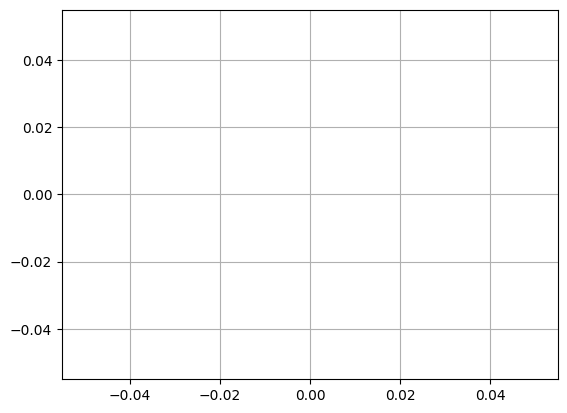

In [89]:
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()